In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

442


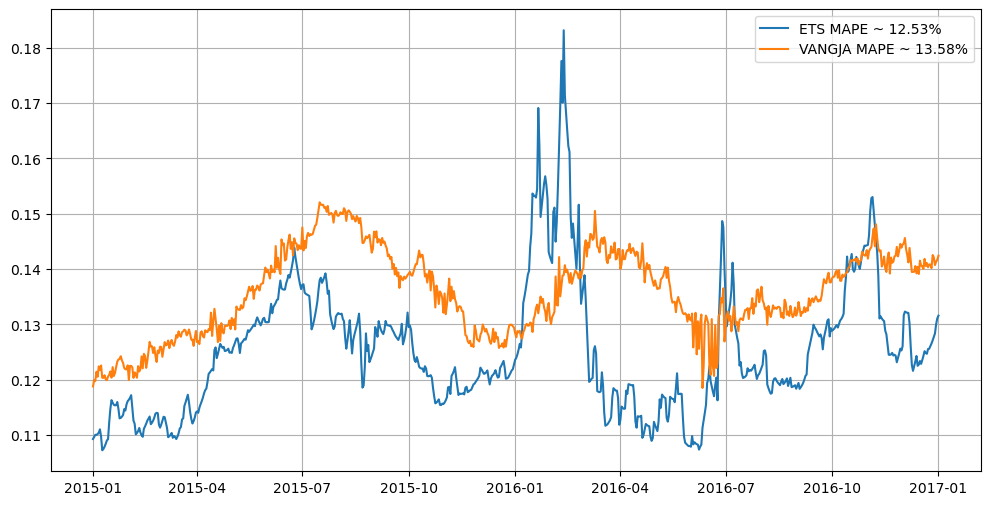

In [5]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
prophet_parent_path = Path("./") / "out" / "es"
vangja_parent_path = Path("./") / "out" / "vangja"

paths = [
    prophet_parent_path,
    vangja_parent_path / "test60",
    # vangja_parent_path / "test_ciit_3",
    # vangja_parent_path / "test_ciit_2",
]
labels = [
    "ETS",
    "VANGJA",
    # "BTL",
    # "BTL + SCALING"
]
index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"{point_str}"
    csv_path = paths[0] / f"{model_name}.csv"
    vangja_path = paths[1] / f"{point_str}.csv"
    # vangja_path2 = paths[2] / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
plt.figure(figsize=(12, 6))

metrics_per_ticker = [{}, {}, {}, {}]
total_metrics = []

for idx, (path, label) in enumerate(zip(paths, labels)):
    dates = []
    mapes = []
    maes = []
    rmses = []
    mses = []
    for point in pd.date_range("2015-01-01", "2017-01-01"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = path / f"{point_str}.csv"

        if not csv_path.is_file():
            continue

        metrics = pd.read_csv(csv_path, index_col=0)
        for ticker in index:
            metrics_per_ticker[idx][ticker] = metrics_per_ticker[idx].get(
                ticker, {"mape": [], "mae": [], "rmse": [], "mse": []}
            )
            metrics_per_ticker[idx][ticker]["mape"].append(metrics.loc[ticker]["mape"])
            metrics_per_ticker[idx][ticker]["mae"].append(metrics.loc[ticker]["mae"])
            metrics_per_ticker[idx][ticker]["rmse"].append(metrics.loc[ticker]["rmse"])
            metrics_per_ticker[idx][ticker]["mse"].append(metrics.loc[ticker]["mse"])

        dates.append(point)
        mapes.append(metrics["mape"].mean())
        maes.append(metrics["mae"].mean())
        rmses.append(metrics["rmse"].mean())
        mses.append(metrics["mse"].mean())

    plt.plot(dates, mapes, label=f"{label} MAPE ~ {100 * sum(mapes) / len(mapes):.2f}%")
    total_metrics.append(
        {
            "mape": sum(mapes) / len(mapes),
            "mae": sum(maes) / len(maes),
            "rmse": sum(rmses) / len(rmses),
            "mse": sum(mses) / len(mses),
        }
    )

plt.grid()
plt.legend()

In [6]:
from vangja.data_utils import (
    download_data,
    generate_train_test_df_around_point,
    process_data,
)

dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

In [7]:
# GIS
best_score = 0
best_ticker = None
best_date = None
best_mapes = None

for ticker, prophet_metrics in metrics_per_ticker[0].items():
    # if ticker in ["DHR", "PRGO", "SLG", "WEC", "SO", "FCX", "MMC", "NTAP", "PSX"]:
    # if ticker in ["GIS"]:
    #     continue
    prophet_mapes = prophet_metrics["mape"]
    vangja_mapes = metrics_per_ticker[1][ticker]["mape"]
    for idx, (prophet_mape, vangja_mape) in enumerate(zip(prophet_mapes, vangja_mapes)):
        score = (prophet_mape - vangja_mape) / prophet_mape
        if score > best_score and vangja_mape < 0.02:
            best_score = score
            best_date = pd.to_datetime("2015-01-01") + pd.to_timedelta(f"{idx} days")
            best_ticker = ticker
            best_mapes = [prophet_mape, vangja_mape]

In [8]:
best_score, best_ticker, best_mapes, best_date

(0.6258466765355921,
 'VRSK',
 [0.0437702505442122, 0.0163767847099868],
 Timestamp('2016-07-25 00:00:00'))

In [9]:
df = None
for ticker in gspc_tickers:
    if ticker["series"].iloc[0] == best_ticker:
        df = ticker

df

,typical_price,ds,series
0,NaN,1962-01-02,VRSK
1,NaN,1962-01-03,VRSK
2,NaN,1962-01-04,VRSK
3,NaN,1962-01-05,VRSK
4,NaN,1962-01-06,VRSK
...,...,...,...
23005,276.964996,2024-12-27,VRSK
23006,276.664162,2024-12-28,VRSK
23007,276.363327,2024-12-29,VRSK
23008,276.062492,2024-12-30,VRSK


In [10]:
def plot(future, y_true, train):
    plt.figure(figsize=(12, 6))
    # plt.title("Forecasts")
    plt.grid()
    plt.plot(
        train["ds"],
        train["y"],
        lw=1,
        # s=0.5,
        # color="C0",
        label="Historical price",
    )
    plt.plot(y_true["ds"], y_true["y"], 
            #  s=0.5, 
            #  color="C1", 
            lw=1,
             label="Target")
    plt.plot(future["ds"], future["yhat"], lw=2, label=r"Forecast")
    plt.legend()

Output()

       mse      rmse       mae      mape
y  0.00039  0.019751  0.015699  0.016377


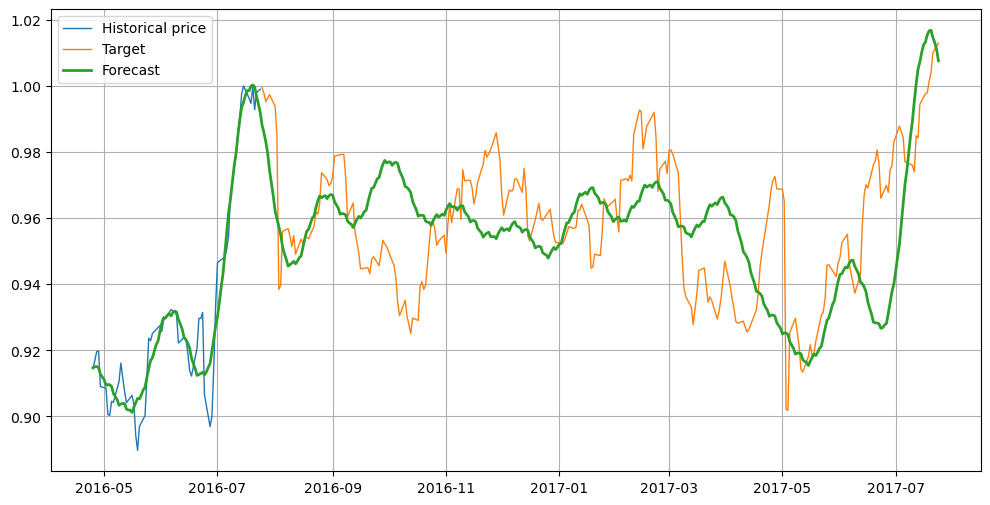

In [17]:
from vangja_simple.components import (
    BetaConstant,
    Constant,
    FourierSeasonality,
    LinearTrend,
)
from vangja_simple.components.normal_constant import NormalConstant
import numpy as np

point = str(pd.to_datetime(best_date)).split(" ")[0]

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365, dfs=smp, for_prophet=False, point=point
)
train_df_tickers, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91,
    horizon=365,
    dfs=[df],
    for_prophet=False,
    point=point,
)

trend = LinearTrend(changepoint_range=1)
yearly = FourierSeasonality(365.25, 10)
weekly = FourierSeasonality(7, 3)
constant = NormalConstant(0, 1/3)
model = trend ** (weekly + constant * yearly)
model.fit(train_df_smp)
first_objs = model.save_model(prophet_parent_path, True)

trend = LinearTrend(n_changepoints=0)
yearly = FourierSeasonality(365.25, 10, allow_tune=True)
weekly = FourierSeasonality(7, 3, allow_tune=True)
constant = NormalConstant(0, 1/3)
model = trend ** (weekly + constant * yearly)
model.load_model(prophet_parent_path, first_objs)
map_approx = pd.read_csv(f"out/vangja/test60/{point}_maps.csv", index_col=0)
row = map_approx.loc[train_df_tickers.iloc[0]["series"]]



model.tune(train_df_tickers, progressbar=False)
for c in row.index:
    try:
        model.map_approx[c] = float(row[c])
    except:
        vals = np.array([float(el) for el in str(row[c]).strip()[1:-1].split(" ") if el != ""])
        model.map_approx[c] = vals
yhat = model.predict(365)
plot(yhat.iloc[-len(train_df_tickers)-len(test_df_tickers):], test_df_tickers, train_df_tickers)
print(model.metrics(test_df_tickers, yhat))

In [18]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    mean_squared_error,
)


def metrics(y_true, yhat, label="y"):
    y = y_true["y"]
    return pd.DataFrame(
        {
            "mse": {f"{label}": mean_squared_error(y, yhat)},
            "rmse": {f"{label}": root_mean_squared_error(y, yhat)},
            "mae": {f"{label}": mean_absolute_error(y, yhat)},
            "mape": {f"{label}": mean_absolute_percentage_error(y, yhat)},
        }
    )

In [19]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.structural import UnobservedComponents

y_train = train_df_tickers.set_index("ds")["y"]
fh = ForecastingHorizon(
    test_df_tickers.set_index("ds").index, is_relative=False
)

arima_forecaster = AutoARIMA(suppress_warnings=True)
arima_forecaster.fit(y=y_train)
y_pred_arima = arima_forecaster.predict(fh=fh)
print(metrics(test_df_tickers, y_pred_arima, label=train_df_tickers["series"].iloc[0]))

es_forecaster = ExponentialSmoothing(seasonal="additive", sp=7)
es_forecaster.fit(y=y_train)
y_pred_es = es_forecaster.predict(fh=fh)
print(
    metrics(
        test_df_tickers, y_pred_es, label=train_df_tickers["series"].iloc[0]
    )
)

uc_forecaster = UnobservedComponents(
    level="local level",
    freq_seasonal=[{"period": 7, "harmonics": 6}, ],
)
uc_forecaster.fit(y=y_train)
y_pred_uc = uc_forecaster.predict(fh=fh)
print(
    metrics(
        test_df_tickers, y_pred_uc, label=train_df_tickers["series"].iloc[0]
    )
)



/home/jovan/anaconda3/envs/pymc_5_20_1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovan/anaconda3/envs/pymc_5_20_1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovan/anaconda3/envs/pymc_5_20_1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovan/anaconda3/envs/pymc_5_20_1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jovan/anaconda3/envs/pymc_5_20_1/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

           mse     rmse       mae     mape
VRSK  0.002088  0.04569  0.041146  0.04339
          mse      rmse      mae     mape
VRSK  0.00212  0.046048  0.04151  0.04377
           mse      rmse       mae      mape
VRSK  0.002118  0.046026  0.041484  0.043743


In [20]:
y_pred_arima

ds
2016-07-25    0.999189
2016-07-26    0.999262
2016-07-27    0.999289
2016-07-28    0.999300
2016-07-29    0.999304
                ...   
2017-07-20    0.999306
2017-07-21    0.999306
2017-07-22    0.999306
2017-07-23    0.999306
2017-07-24    0.999306
Name: y, Length: 365, dtype: float64

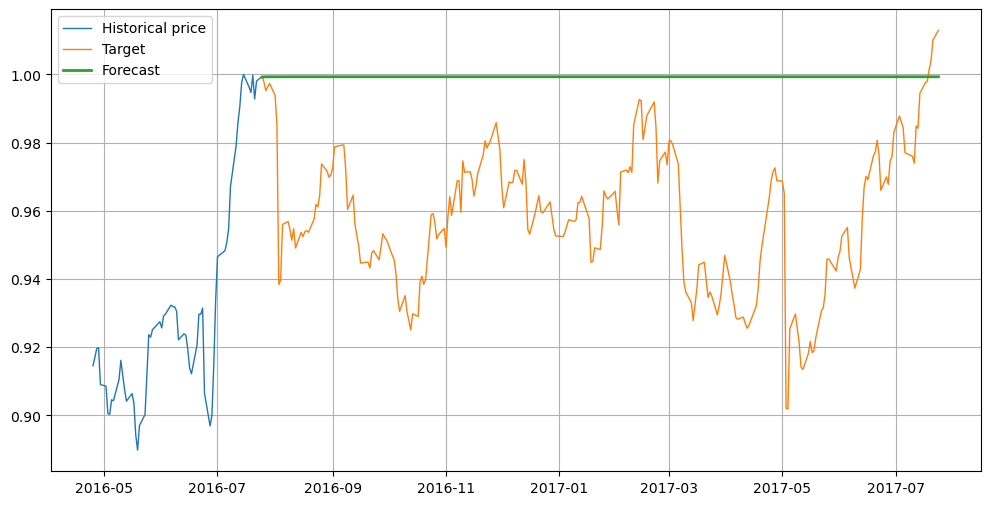

In [26]:
plot(pd.DataFrame({"ds": y_pred_arima.index, "yhat": y_pred_arima}).reset_index(drop=True), test_df_tickers, train_df_tickers)


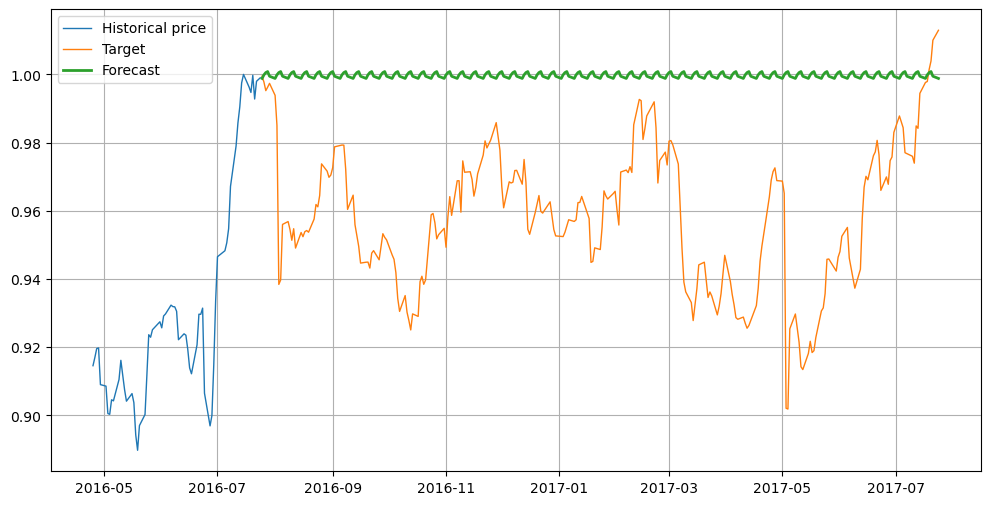

In [27]:
plot(pd.DataFrame({"ds": y_pred_es.index, "yhat": y_pred_es}).reset_index(drop=True), test_df_tickers, train_df_tickers)

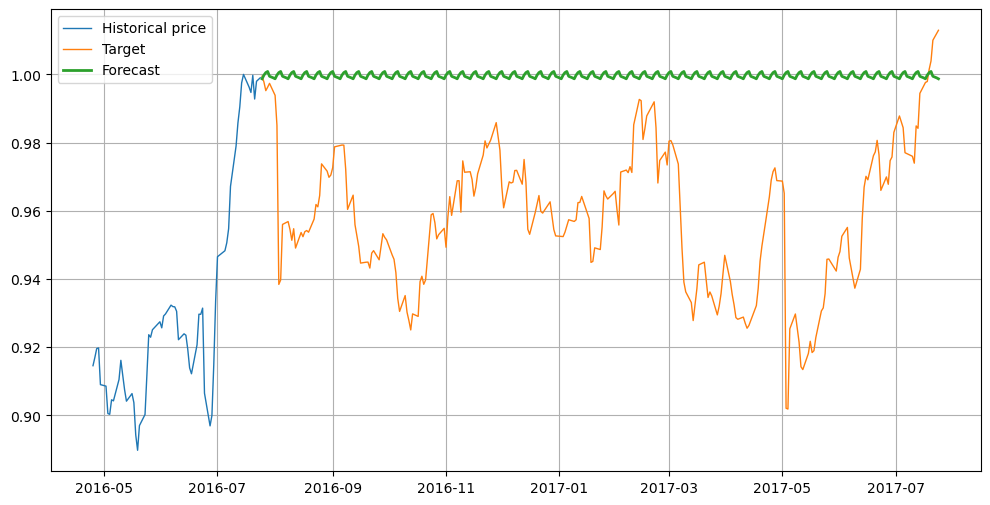

In [28]:
plot(pd.DataFrame({"ds": y_pred_uc.index, "yhat": y_pred_uc}).reset_index(drop=True), test_df_tickers, train_df_tickers)